# Step 1 : Extraction of Data from Table for PhotoZ estimation
<img align="left" src = figs/logos/logo-IJCLab_v1.png width=250, style="padding: 10px"> 
<b>Extract measured fluxes from Object table and redshift from thruth Table and save it in a file for later use</b> <br>
Last verified to run on 2022-11-20 with LSST Science Pipelines release w_2022_40 <br>
Contact authors: Sylvie Dagoret-Campagne (DP0 Delegate) <br>
Target audience: DP0 delegates member <br>

The extraction of the data is inspired from the tutorial notebook https://github.com/rubin-dp0/tutorial-notebooks/blob/main/08_Truth_Tables.ipynb

# 1) Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.units import UnitsWarning
from astropy.table import Table
import warnings

In [2]:
# Access to data via TAP service
from lsst.rsp import get_tap_service, retrieve_query

In [3]:
# Access to data via Butler
import lsst.daf.butler as dafButler
import lsst.geom as geom

In [4]:
import pickle
import os
import errno
import shutil
import getpass

In [5]:
warnings.simplefilter("ignore", category=UnitsWarning)
pd.set_option('display.max_rows', 200)

In [6]:
%matplotlib inline

In [7]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

In [8]:
params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [18, 10],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

# 2) Configuration

Set up colors and plot symbols corresponding to the _ugrizy_ bands. These colors are the same as those used for _ugrizy_ bands in Dark Energy Survey (DES) publications, and are defined in <a href="https://github.com/DarkEnergySurvey/descolors">this github repository</a>.

In [9]:
plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

### Angles in degrees

- Select the sky region in RA and DEC. 

In [10]:
RA=62
DEC=-37
use_center_coords = "62, -37"
use_radius = "0.5"

### Magnitude limit

- Want to put threshold on the magnitude of retrieved object to reasonable ones

In [11]:
MAGLIMMIN = 17
MAGLIMMAX = 26

In [12]:
# username
myusername=getpass.getuser()

In [13]:
# temporary folders if necessary
NBDIR       = 'photoz_dp02'                       # relative path for this notebook output
TMPTOPDIR   = "/scratch"                          # always write some output in /scratch, never in user HOME 
TMPUSERDIR  = os.path.join(TMPTOPDIR,myusername)  # defines the path of user outputs in /scratch 
TMPNBDIR    = os.path.join(TMPUSERDIR,NBDIR)      # output path for this particular notebook

In [14]:
FLAG_WRITE_DATAFRAMEONDISK  = True   # Select if query output will be saved on disk
FLAG_READ_DATAFRAMEFROMDISK = True   # Select if the query can be red from disk if it exists
FLAG_CLEAN_DATAONDISK       = False  # Select if the output queries saved in file will be cleaned at the end of the notebook

In [15]:
filename_result=f'fluxesredshift_result.pkl'
filename_result_skyinfo=f'tractpatch_result.csv'
fullfilename_result=os.path.join(TMPNBDIR,filename_result)
fullfilename_result_skyinfo=os.path.join(TMPNBDIR,filename_result_skyinfo)

# 3) Initialization

- create output directories of missing

In [16]:
# create user temporary directory
if not os.path.isdir(TMPUSERDIR):
    try:
        os.mkdir(TMPUSERDIR)
    except:
        raise OSError(f"Can't create destination directory {TMPUSERDIR}!" ) 

In [17]:
# create this notebook temporary directory
if not os.path.isdir(TMPNBDIR):
    try:
        os.mkdir(TMPNBDIR)
    except:
        raise OSError(f"Can't create destination directory {TMPNBDIR}!" ) 

# 4) Access to data 

## 4.1 Table available to TAP service on DC2 simulation and its processing by DM 

To access tables, we will use the TAP service in a similar manner to what we showed in the [Intro to DP0 notebook](https://github.com/rubin-dp0/tutorial-notebooks/blob/main/01_Intro_to_DP0_Notebooks.ipynb), and explored further in the [TAP tutorial notebook](https://github.com/rubin-dp0/tutorial-notebooks/blob/main/02_Intermediate_TAP_Query.ipynb). See those notebooks for more details.

In [18]:
service = get_tap_service()

###  List of the available catalogs & tables

The <a href="dp0-2.lsst.io">DP0.2 Documentation</a> contains a <a href="https://dp0-2.lsst.io/data-products-dp0-2/index.html#catalogs">list of all DP0.2 catalogs</a>, and also a link to the <a href="https://dm.lsst.org/sdm_schemas/browser/dp02.html">DP0.2 Schema Browser</a> where users can read about the available tables and their contents.

- https://dp0-2.lsst.io/data-products-dp0-2/index.html

- https://dm.lsst.org/sdm_schemas/browser/dp02.html

#### Print the names of all available tables

In [19]:
results = service.search("SELECT description, table_name FROM TAP_SCHEMA.tables")
results_tab = results.to_table()

for tablename in results_tab['table_name']:
    print(tablename)

dp01_dc2_catalogs.forced_photometry
dp01_dc2_catalogs.object
dp01_dc2_catalogs.position
dp01_dc2_catalogs.reference
dp01_dc2_catalogs.truth_match
dp02_dc2_catalogs.CcdVisit
dp02_dc2_catalogs.CoaddPatches
dp02_dc2_catalogs.DiaObject
dp02_dc2_catalogs.DiaSource
dp02_dc2_catalogs.ForcedSource
dp02_dc2_catalogs.ForcedSourceOnDiaObject
dp02_dc2_catalogs.MatchesTruth
dp02_dc2_catalogs.Object
dp02_dc2_catalogs.Source
dp02_dc2_catalogs.TruthSummary
dp02_dc2_catalogs.Visit
ivoa.ObsCore
tap_schema.columns
tap_schema.key_columns
tap_schema.keys
tap_schema.schemas
tap_schema.tables
uws.Job


In [20]:
for c, columnname in enumerate(results['table_name']):
    print('%-25s : --> \t %-200s ' % (columnname, results['description'][c]))

dp01_dc2_catalogs.forced_photometry : --> 	 Forced photometry measurements for objects detected in the coadded images, at the locations defined by the position table. (747 columns)                                                                 
dp01_dc2_catalogs.object  : --> 	 The object table from the DESC DC2 simulated sky survey as described in arXiv:2101.04855. Includes astrometric and photometric parameters for objects detected in coadded images. (137 columns)          
dp01_dc2_catalogs.position : --> 	 Select astrometry-related parameters for objects detected in the coadded images, such as coordinates, footprints, patch/tract information, and deblending parameters. (29 columns)                       
dp01_dc2_catalogs.reference : --> 	 Measurements for objects detected in the coadded images, including photometry, astrometry, shape, deblending, model fits, and related background and flag parameters. This table joined with the position table is very similar to the object table, 

In [21]:
del results, results_tab

### Object Table

- https://dm.lsst.org/sdm_schemas/browser/dp02.html#Object

### MatchesTruth Table

- https://dm.lsst.org/sdm_schemas/browser/dp02.html#MatchesTruth

In [22]:
results = service.search("SELECT column_name, datatype, description,\
                          unit from TAP_SCHEMA.columns\
                          WHERE table_name = 'dp02_dc2_catalogs.MatchesTruth'")

In [23]:
results.to_table().to_pandas()

,column_name,datatype,description,unit
0,id,char,id for TruthSummary source. Potentially non-un...,
1,id_truth_type,char,Combination of TruthSummary id and truth_type ...,
2,match_candidate,boolean,True for sources that were selected for matching,
3,match_chisq,double,The chi-squared value of the (best) match,
4,match_count,int,Number of candidate object matches within matc...,
5,match_n_chisq_finite,int,The number of finite columns used to compute t...,
6,match_objectId,long,"objectId of matched entry in the Object table,...",
7,truth_type,long,"Type of TruthSummary source; 1 for galaxies, 2...",


The above is fine if the full description is not needed, but there are some important details that are being hidden by the line truncation above.

Try this instead.

In [24]:
for c, columnname in enumerate(results['column_name']):
    print('%-25s %-200s' % (columnname, results['description'][c]))

id                        id for TruthSummary source. Potentially non-unique; use id_truth_type for JOINs.                                                                                                                        
id_truth_type             Combination of TruthSummary id and truth_type fields, used for JOINs.                                                                                                                                   
match_candidate           True for sources that were selected for matching                                                                                                                                                        
match_chisq               The chi-squared value of the (best) match                                                                                                                                                               
match_count               Number of candidate object matches within match radius            

In [25]:
del results

### TruthSummary Table

- https://dm.lsst.org/sdm_schemas/browser/dp02.html#TruthSummary

In [26]:
results = service.search("SELECT column_name, datatype, description,\
                          unit from TAP_SCHEMA.columns\
                          WHERE table_name = 'dp02_dc2_catalogs.TruthSummary'")

In [27]:
# results.to_table().to_pandas()

In [28]:
for c, columnname in enumerate(results['column_name']):
    print('%-25s %-200s' % (columnname, results['description'][c]))

cosmodc2_hp               Healpix ID in cosmoDC2 (for galaxies only; -1 for stars and SNe)                                                                                                                                        
cosmodc2_id               Galaxy ID in cosmoDC2 (for galaxies only; -1 for stars and SNe)                                                                                                                                         
dec                       Declination                                                                                                                                                                                             
flux_g                    Static flux value in g                                                                                                                                                                                  
flux_g_noMW               Static flux value in g, without Milky Way extinction (i.e., deredd

In [29]:
del results

## 4.2) Build the ADQL query to retrieve usefull data for Photoz 

Make a triple join tables:

-- **dp02_dc2_catalogs.MatchesTruth** : the table that allow to match the object entries in the Truth table and DM reconstruction

-- **dp02_dc2_catalogs.TruthSummary** : the table that conains true CosmoDC2 values

-- **dp02_dc2_catalogs.Object**: The table of object generated by Rubin DM pipelines


### Retrieve additional data for true galaxies that are matched to detected objects

With the query below we retrieve much more data for true galaxies, such as their true and measured fluxes and extendedness. Since we are only retrieving measurement data from the Object table for true galaxies, we retrieve the `cModelFlux` instead of the `psfFlux`, the latter being appropriate for point-sources (e.g., stars).

> **Notice:** Above, the column names in the retrieved results have no provenance: once the data is in the results table, it is unclear from which table it originated (i.e., whether it is a true coordinate or a measured coordinate). Below, we use the `AS` statement to rename columns to start with their origin table, in order to keep track of what is from a truth table (mt_ and ts_) and what is from the object table (obj_).

> **Notice:** Below, we use `truth_type = 1` to only retrieve truth and measurement data for "true galaxies."


In [30]:
my_adql_query = "SELECT mt.id_truth_type AS mt_id_truth_type, "\
        "mt.match_objectId AS mt_match_objectId, "\
        "ts.ra AS ts_ra, "\
        "ts.dec AS ts_dec, "\
        "ts.truth_type AS ts_truth_type, "\
        "ts.mag_r AS ts_mag_r, "\
        "ts.is_pointsource AS ts_is_pointsource, "\
        "ts.redshift AS ts_redshift, "\
        "ts.flux_u AS ts_flux_u, "\
        "ts.flux_g AS ts_flux_g, "\
        "ts.flux_r AS ts_flux_r, "\
        "ts.flux_i AS ts_flux_i, "\
        "ts.flux_z AS ts_flux_z, "\
        "ts.flux_y AS ts_flux_y, "\
        "obj.coord_ra AS obj_coord_ra, "\
        "obj.coord_dec AS obj_coord_dec, "\
        "obj.u_cModelFlux AS obj_u_cModelFlux, "\
        "obj.g_cModelFlux AS obj_g_cModelFlux, "\
        "obj.r_cModelFlux AS obj_r_cModelFlux, "\
        "obj.i_cModelFlux AS obj_i_cModelFlux, "\
        "obj.z_cModelFlux AS obj_z_cModelFlux, "\
        "obj.y_cModelFlux AS obj_y_cModelFlux, "\
        "scisql_nanojanskyToAbMag(obj.u_cModelFlux) AS obj_u_cModelMag, "\
        "scisql_nanojanskyToAbMag(obj.g_cModelFlux) AS obj_g_cModelMag, "\
        "scisql_nanojanskyToAbMag(obj.r_cModelFlux) AS obj_r_cModelMag, "\
        "scisql_nanojanskyToAbMag(obj.i_cModelFlux) AS obj_i_cModelMag, "\
        "scisql_nanojanskyToAbMag(obj.z_cModelFlux) AS obj_z_cModelMag, "\
        "scisql_nanojanskyToAbMag(obj.y_cModelFlux) AS obj_y_cModelMag "\
        "FROM dp02_dc2_catalogs.MatchesTruth AS mt "\
        "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "\
        "JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId "\
        "WHERE CONTAINS(POINT('ICRS', ts.ra, ts.dec), CIRCLE('ICRS'," + use_center_coords + ", " + use_radius + ")) = 1 "\
        "AND ts.truth_type = 1 "\
        "AND obj.detect_isPrimary = 1 "\
        "AND scisql_nanojanskyToAbMag(obj.g_cModelFlux) > " + str(MAGLIMMIN) + " " + \
        "AND scisql_nanojanskyToAbMag(obj.g_cModelFlux) < " + str(MAGLIMMAX) + " " + \
        "AND scisql_nanojanskyToAbMag(obj.r_cModelFlux) > " + str(MAGLIMMIN) + " " + \
        "AND scisql_nanojanskyToAbMag(obj.r_cModelFlux) < " + str(MAGLIMMAX) + " " + \
        "AND scisql_nanojanskyToAbMag(obj.i_cModelFlux) > " + str(MAGLIMMIN) + " " + \
        "AND scisql_nanojanskyToAbMag(obj.i_cModelFlux) < " + str(MAGLIMMAX) + " " + \
        "AND obj.refExtendedness IS NOT NULL "
print(my_adql_query)

SELECT mt.id_truth_type AS mt_id_truth_type, mt.match_objectId AS mt_match_objectId, ts.ra AS ts_ra, ts.dec AS ts_dec, ts.truth_type AS ts_truth_type, ts.mag_r AS ts_mag_r, ts.is_pointsource AS ts_is_pointsource, ts.redshift AS ts_redshift, ts.flux_u AS ts_flux_u, ts.flux_g AS ts_flux_g, ts.flux_r AS ts_flux_r, ts.flux_i AS ts_flux_i, ts.flux_z AS ts_flux_z, ts.flux_y AS ts_flux_y, obj.coord_ra AS obj_coord_ra, obj.coord_dec AS obj_coord_dec, obj.u_cModelFlux AS obj_u_cModelFlux, obj.g_cModelFlux AS obj_g_cModelFlux, obj.r_cModelFlux AS obj_r_cModelFlux, obj.i_cModelFlux AS obj_i_cModelFlux, obj.z_cModelFlux AS obj_z_cModelFlux, obj.y_cModelFlux AS obj_y_cModelFlux, scisql_nanojanskyToAbMag(obj.u_cModelFlux) AS obj_u_cModelMag, scisql_nanojanskyToAbMag(obj.g_cModelFlux) AS obj_g_cModelMag, scisql_nanojanskyToAbMag(obj.r_cModelFlux) AS obj_r_cModelMag, scisql_nanojanskyToAbMag(obj.i_cModelFlux) AS obj_i_cModelMag, scisql_nanojanskyToAbMag(obj.z_cModelFlux) AS obj_z_cModelMag, scisql_nan

### Asynchronous query

In [31]:
if FLAG_READ_DATAFRAMEFROMDISK and os.path.exists(fullfilename_result):
    df = pd.read_pickle(fullfilename_result)
    results = Table.from_pandas(df)

else:
    # Create and submit the job. This step does not run the query yet
    job = service.submit_job(my_adql_query,maxrec=1_000_000)
    # Get the job URL
    print('Job URL is', job.url)

    # Get the job phase. It will be pending as we have not yet started the job
    print('Job phase is', job.phase)
    
    # Run the job. You will see that the the cell completes executing,
    # even though the query is still running
    job.run()
    
    # Use this to tell python to wait for the job to finish if
    # you don't want to run anything else while waiting
    # The cell will continue executing until the job is finished
    job.wait(phases=['COMPLETED', 'ERROR'])
    print('Job phase is', job.phase)
    
    # A usefull funtion to raise an exception if there was a problem with the query
    job.raise_if_error()
    
    # Once the job completes successfully, you can fetch the results
    async_tract_data = job.fetch_result()
    results = async_tract_data.to_table()
    
    
if FLAG_WRITE_DATAFRAMEONDISK:
    results.to_pandas().to_pickle(fullfilename_result)

### synchronous query

In [32]:
#%%time
#results = service.search(my_adql_query)

In [33]:
t=results

### Set table print format

In [34]:
for column_name in t.colnames:
    typ=t[column_name].dtype
    if typ== 'float32' or typ=='float64':
         t[column_name].format = "{:.2f}"
t        

mt_id_truth_type,mt_match_objectId,ts_ra,ts_dec,ts_truth_type,ts_mag_r,ts_is_pointsource,ts_redshift,ts_flux_u,ts_flux_g,ts_flux_r,ts_flux_i,ts_flux_z,ts_flux_y,obj_coord_ra,obj_coord_dec,obj_u_cModelFlux,obj_g_cModelFlux,obj_r_cModelFlux,obj_i_cModelFlux,obj_z_cModelFlux,obj_y_cModelFlux,obj_u_cModelMag,obj_g_cModelMag,obj_r_cModelMag,obj_i_cModelMag,obj_z_cModelMag,obj_y_cModelMag
str12,int64,float64,float64,int64,float32,int32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
7941880022_1,1651413688361451734,61.87,-36.52,1,26.69,0,1.30,102.02,90.72,76.28,66.37,77.86,86.15,61.87,-36.52,144.35,176.65,191.87,159.32,381.49,0.00,26.00,25.78,25.69,25.89,24.95,--
7939461442_1,1651413688361451864,61.94,-36.52,1,26.00,0,0.95,109.06,113.45,144.91,268.33,375.21,382.82,61.94,-36.52,195.67,192.19,212.29,488.63,634.48,1091.38,25.67,25.69,25.58,24.68,24.39,23.81
7939458371_1,1651413688361450903,61.84,-36.52,1,23.65,0,0.95,901.93,893.60,1259.65,2368.33,3736.82,4296.35,61.84,-36.52,1387.67,1565.22,2062.92,3226.16,5167.70,5953.20,23.54,23.41,23.11,22.63,22.12,21.96
7940601535_1,1651413688361451151,61.89,-36.52,1,23.48,0,1.14,1177.57,1248.37,1474.26,1851.70,3567.98,4261.64,61.89,-36.52,1253.52,1375.73,1555.52,2007.93,3577.96,4435.08,23.65,23.55,23.42,23.14,22.52,22.28
7938042672_1,1651413688361451083,61.95,-36.53,1,23.20,0,0.58,573.07,878.14,1902.55,3165.14,3817.33,4459.44,61.95,-36.53,529.25,892.57,1943.69,3379.12,3879.09,4958.23,24.59,24.02,23.18,22.58,22.43,22.16
7941544989_1,1651413688361451141,61.84,-36.52,1,24.91,0,1.31,357.04,354.05,393.56,461.54,695.44,1037.74,61.84,-36.52,331.04,339.62,405.30,438.31,750.46,1247.81,25.10,25.07,24.88,24.80,24.21,23.66
7940893415_1,1651413688361451140,61.84,-36.53,1,24.96,0,1.15,354.31,282.46,375.62,487.19,920.02,1115.62,61.84,-36.53,450.24,361.43,480.29,623.51,1054.09,1744.87,24.77,25.00,24.70,24.41,23.84,23.30
7938684807_1,1651413688361451139,61.84,-36.52,1,25.55,0,0.77,145.11,155.15,218.09,424.95,505.95,551.23,61.84,-36.52,344.18,358.13,541.26,994.66,1174.51,1529.23,25.06,25.01,24.57,23.91,23.73,23.44
7939458378_1,1651413688361451138,61.84,-36.52,1,23.62,0,0.95,159.56,303.27,1289.22,3222.59,6677.94,9195.84,61.84,-36.52,232.26,339.26,1238.08,2967.54,6332.50,8914.84,25.49,25.07,23.67,22.72,21.90,21.52


## 4.3) Access to Data via the Butler

Butler repositories have both a database component and a file-like storage component.
The database component can be accessed through the Butler registry, while file-like storage can be local (i.e., pointing to a directory on the local file system) or remote (i.e., pointing to cloud storage resources).
DP0 uses Simple Storage Service (S3) buckets, which are public cloud storage resources that are similar to file folders.
The S3 buckets store objects, which consist of data and its descriptive metadata.

### Butler initialization

In [35]:
butler = dafButler.Butler('dp02', collections='2.2i/runs/DP0.2')

The database side of a data repository is called a `registry`.
The registry contains entries for all data products, and organizes them by _collections_, _dataset types_, and _data IDs_.
We can access a registry client directly as part of our Butler object:

### Check datasets available through Butler

In [36]:
registry = butler.registry

#### Collections

In [37]:
for c in sorted(registry.queryCollections()):
    if (c == '2.2i/runs/DP0.1') | (c == '2.2i/runs/DP0.2'):
        print(c)

2.2i/runs/DP0.1
2.2i/runs/DP0.2


#### Datasets

In [38]:
#for dt in sorted(registry.queryDatasetTypes()):
#    print(dt)

In [39]:
#for dt in sorted(registry.queryDatasetTypes('*object*')):
#    print(dt)

In [40]:
for dt in sorted(registry.queryDatasetTypes('*_tract')):
    print(dt)

DatasetType('diaObjectTable_tract', {skymap, tract}, DataFrame)
DatasetType('diaSourceTable_tract', {skymap, tract}, DataFrame)
DatasetType('diff_matched_truth_summary_objectTable_tract', {skymap, tract}, DataFrame)
DatasetType('forcedSourceOnDiaObjectTable_tract', {skymap, tract}, DataFrame)
DatasetType('forcedSourceTable_tract', {skymap, tract}, DataFrame)
DatasetType('match_ref_truth_summary_objectTable_tract', {skymap, tract}, DataFrame)
DatasetType('match_target_truth_summary_objectTable_tract', {skymap, tract}, DataFrame)
DatasetType('matched_truth_summary_objectTable_tract', {skymap, tract}, DataFrame)
DatasetType('objectTable_tract', {skymap, tract}, DataFrame)


In [41]:
#for dt in sorted(registry.queryDatasetTypes('*object*')):
#    print(dt)

#### DeepCoadds and Objects

##### Data Id and data access in deepCoadd table

- data can be accessed by tract and patch (not RA, DEC)
- thus One need to know correspondence between RA,DEC <--> Tract,Patch

In [42]:
coaddId = {'tract': 4226, 'patch': 17, 'band': 'r'}
coadd = butler.get('deepCoadd', dataId=coaddId)

In [43]:
# Dump the individual visits of this coadd
#coaddInfo = coadd.getInfo()
#coaddVisits = coaddInfo.getCoaddInputs().visits
#coaddVisits.asAstropy()

In [44]:
#coadd_objects = butler.get('objectTable_tract', dataId=coaddId)
#print(len(coadd_objects)

In [45]:
#co_ra = coadd_objects.coord_ra.values
#co_dec = coadd_objects.coord_dec.values
#co_cF = coadd_objects.r_calibFlux.values
#co_cFf = coadd_objects.r_calibFlux_flag.values
#co_diP = coadd_objects.detect_isPrimary.values
#tx = np.where((co_diP) & (co_cF > 0.0) & (co_cFf == 0))[0]
#print('Number of coadd objects to plot: ', len(tx))

#### But need to know where is the tract and patch

- the easiest way to know in which tract and patches the DC2 data are distributed is to makea TAP query

In [46]:
if FLAG_READ_DATAFRAMEFROMDISK and os.path.exists(fullfilename_result_skyinfo):
    # read sky info (tract,patches) from disk
    df = pd.read_csv(fullfilename_result_skyinfo,index_col=0)
    results_skyinfo = Table.from_pandas(df)

else:
    # retrieve sky info (tract,patches) from TAP service
    sync_tract_data = service.search("select tract,patch, \
    min(coord_ra) as minRA, \
    max(coord_ra) as maxRA, \
    min(coord_dec) as minDEC,\
    max(coord_dec) as maxDEC ,\
    avg(coord_ra) as meanRA, \
    avg(coord_dec) as meanDEC,\
    count(*) as num \
    from dp02_dc2_catalogs.Object group by tract,patch")
      
    results_skyinfo = sync_tract_data.to_table()
    
# Save for later use    
if FLAG_WRITE_DATAFRAMEONDISK:
    results_skyinfo.to_pandas().to_csv(fullfilename_result_skyinfo)

#### Show table of tract and patches

In [47]:
#results_skyinfo

In [48]:
df_results_skyinfo = results_skyinfo.to_pandas().reset_index(drop=True)
df_results_skyinfo.drop(df_results_skyinfo.columns[df_results_skyinfo.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [49]:
df_results_skyinfo.head()

,tract,patch,minRA,maxRA,minDEC,maxDEC,meanRA,meanDEC,num
0,2897,0,51.618138,51.940079,-44.659022,-44.429505,51.778683,-44.539377,31027
1,2897,1,51.306939,51.635479,-44.660667,-44.431957,51.470803,-44.543630,31819
2,2897,2,50.995756,51.323245,-44.661524,-44.433645,51.157853,-44.543645,28954
3,2897,3,50.683944,51.010891,-44.661639,-44.434518,50.845443,-44.543454,30291
4,2897,4,50.371578,50.699079,-44.661533,-44.433656,50.534933,-44.544366,30738


#### Get list of tracts

In [50]:
list_of_tracts = np.unique(df_results_skyinfo['tract'].values)
list_of_tracts

array([2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907,
       2908, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083,
       3084, 3085, 3086, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263,
       3264, 3265, 3266, 3267, 3268, 3441, 3442, 3443, 3444, 3445, 3446,
       3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3631, 3632, 3633,
       3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3825,
       3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836,
       3837, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031,
       4032, 4033, 4034, 4035, 4224, 4225, 4226, 4227, 4228, 4229, 4230,
       4231, 4232, 4233, 4234, 4235, 4236, 4429, 4430, 4431, 4432, 4433,
       4434, 4435, 4436, 4437, 4438, 4439, 4440, 4441, 4636, 4637, 4638,
       4639, 4640, 4641, 4642, 4643, 4644, 4645, 4646, 4647, 4648, 4848,
       4849, 4850, 4851, 4852, 4853, 4854, 4855, 4856, 4857, 4858, 4859,
       4860, 5062, 5063, 5064, 5065, 5066, 5067, 50

#### Min RA and Max RA and Min DEC and Max DEC for tracts

In [51]:
patch_coords = df_results_skyinfo.groupby(['tract']).mean().sort_values(by="tract")

In [52]:
patch_coords.drop(columns=["patch","minRA","maxRA","minDEC","maxDEC","num"],inplace=True)

In [53]:
patch_coords.head()

,meanRA,meanDEC
tract,,
2897,50.847278,-43.882198
2898,52.881212,-43.881946
2899,54.915204,-43.881658
2900,56.949101,-43.881727
2901,58.982980,-43.881880


### Access to list of tracts & patches from skyMap structure in Butler

In [54]:
skymap = butler.get('skyMap')

In [55]:
numTracts=0
patches = []
# loop on tract
for tractInfo in skymap:
    tractID = tractInfo.getId()
    
    # exclude tract not having any objects in (outside DC2 data)
    if tractID not in list_of_tracts:
        continue
        
    # WCS for that patch
    tWCS=tractInfo.getWcs()
    
    # loop on patches inside the tract
    for patch in tractInfo:
          
        pID = patch.sequential_index
        ibb=patch.getInnerBBox()
        
        # corners of the patch 
        corners = []
        # loop on corners of the patch
        for corner in ibb.getCorners():
            p = geom.Point2D(corner.getX(), corner.getY())
            coord = tWCS.pixelToSky(p)
            corners.append([coord.getRa().asDegrees(), coord.getDec().asDegrees()])
            polygon = Polygon(corners,True)
            patches.append(polygon)
    numTracts+=1
 
print(numTracts)        

157


Text(0.5, 1.0, 'Setting of tracts and patches (DC2 simulation)')

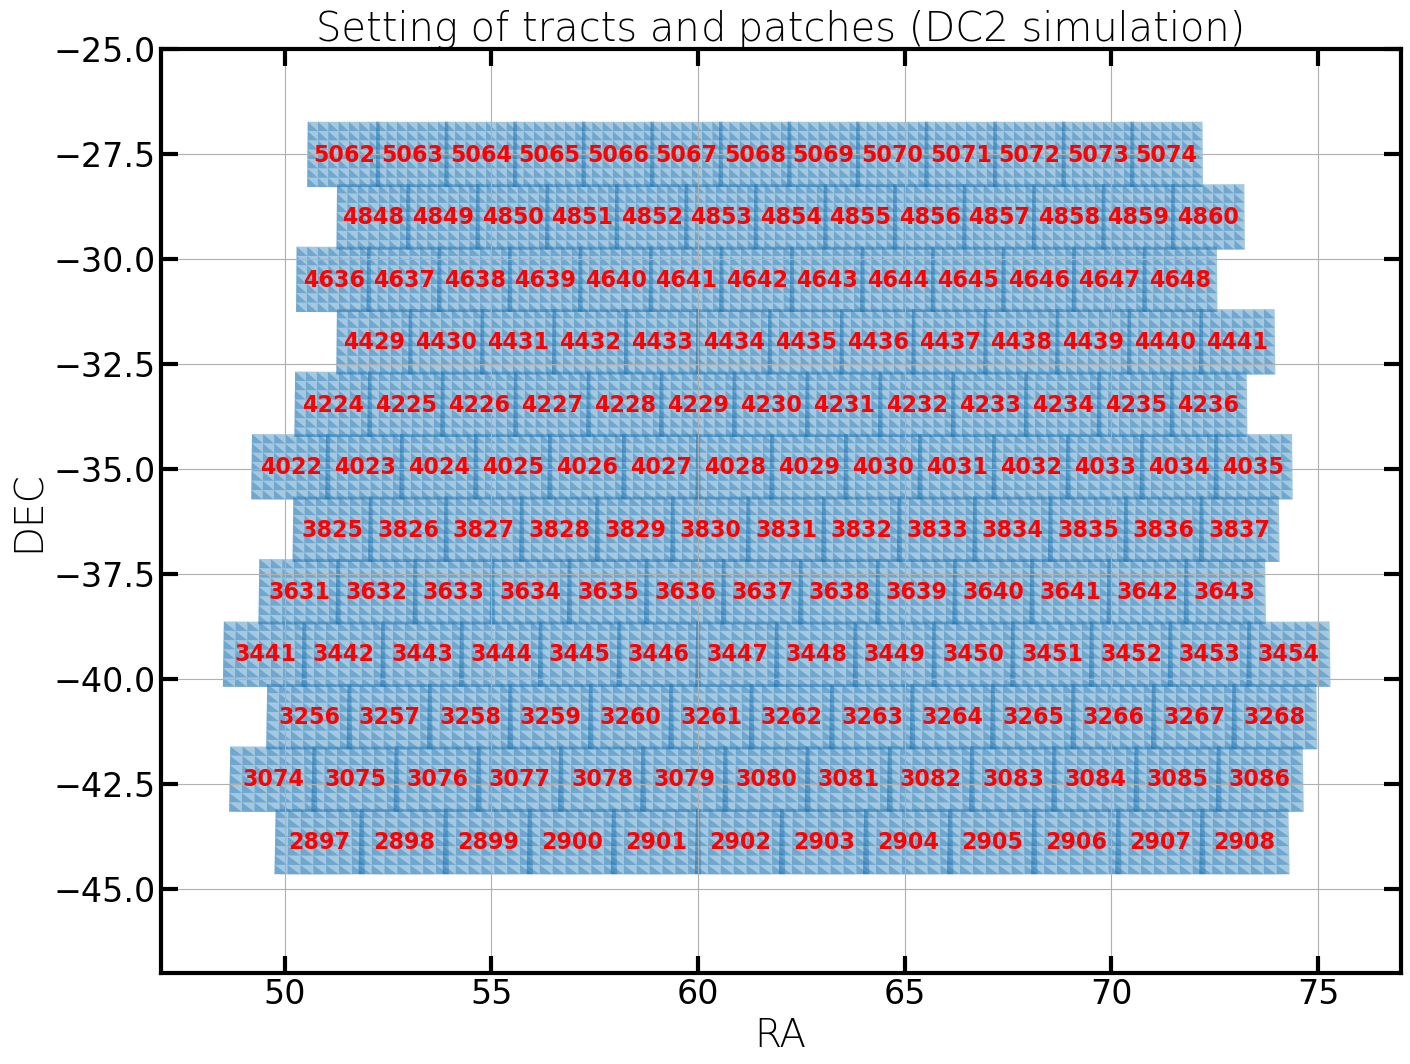

In [56]:
fig, ax = plt.subplots(figsize=(16,12))
p = PatchCollection(patches, cmap="jet", alpha=0.4)
ax.add_collection(p)  

for index, row in patch_coords.iterrows():
    x=row["meanRA"]
    y=row["meanDEC"]      
    ax.text(x, y, str(index),horizontalalignment='center',verticalalignment='center',fontsize=16,fontweight="bold",color="red")
    
ax.grid()
ax.set_xlim([47, 77])
ax.set_xlabel('RA')
ax.set_ylim([-47, -25])
ax.set_ylabel('DEC')
ax.set_title("Setting of tracts and patches (DC2 simulation)")

# 5) Check extracted data

## 5.1) Compare true and measured properties for true galaxies

### Plot coordinate offsets for true galaxies

Below, plot the difference between the true and measured declination versus the difference between the true and measured right ascension. 

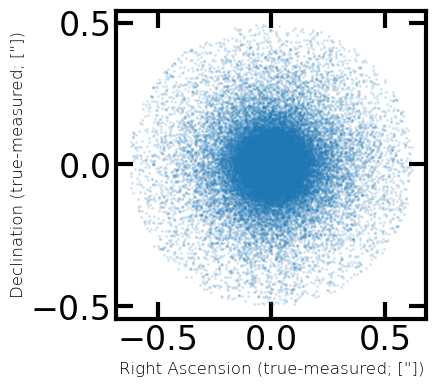

In [57]:
fig = plt.figure(figsize=(4, 4))
plt.plot(3600*(results['ts_ra']-results['obj_coord_ra']), \
         3600*(results['ts_dec']-results['obj_coord_dec']), \
         'o', ms=2, alpha=0.2, mew=0)
plt.xlabel('Right Ascension (true-measured; ["])', fontsize=12)
plt.ylabel('Declination (true-measured; ["])', fontsize=12)
plt.show()

We see that the scatter is less than about 0.5 arcseconds. For the (DC2-simulated) LSST Science Camera's platescale of 0.2 arcsec per pixel, that's a measurement accuracy of 2.5 pixels. Note also that most galaxies' positions are measured to sub-pixel accuracy.

### Compare true and measured r-band magnitudes for true galaxies

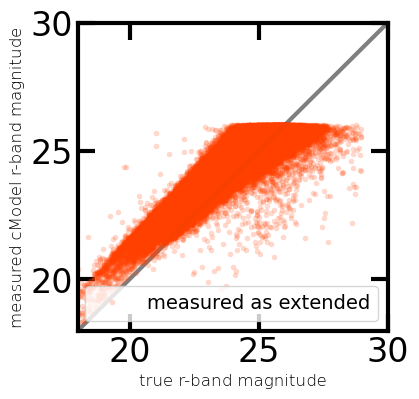

In [58]:
fig = plt.figure(figsize=(4, 4))
plt.plot([18,32], [18,32], ls='solid', color='black', alpha=0.5)
plt.plot(results['ts_mag_r'], results['obj_g_cModelMag'], \
         'o', ms=4, alpha=0.2, mew=0, color=plot_filter_colors['r'],\
         label='measured as extended')



plt.xlabel('true r-band magnitude', fontsize=12)
plt.ylabel('measured cModel r-band magnitude', fontsize=12)
plt.legend(loc='lower right')
plt.xlim([18,30])
plt.ylim([18,30])
plt.show()

### Compare true and measured fluxes in all filters for true galaxies

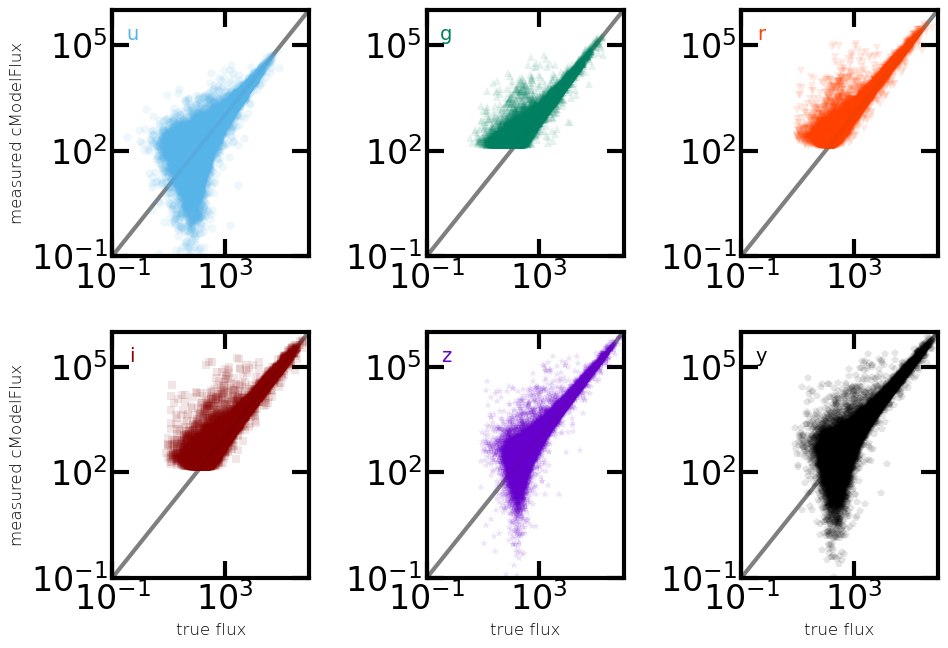

In [59]:
fig, ax = plt.subplots(2, 3, figsize=(10, 7))
i=0
j=0
for f,filt in enumerate(plot_filter_labels):
    ax[i,j].plot([0.1,1e6], [0.1,1e6], ls='solid', color='black', alpha=0.5)
    ax[i,j].plot(results['ts_flux_'+filt], results['obj_'+filt+'_cModelFlux'], \
                 plot_filter_symbols[filt], color=plot_filter_colors[filt], \
                 alpha=0.1, mew=0, label=filt)
    ax[i,j].loglog()
    ax[i,j].text(0.1, 0.9, filt, horizontalalignment='center', verticalalignment='center',
                 transform = ax[i,j].transAxes, color=plot_filter_colors[filt], fontsize=14)
    ax[i,j].set_xlim([0.1,1e6])
    ax[i,j].set_ylim([0.1,1e6])
    j += 1
    if j == 3:
        i += 1
        j = 0
ax[0,0].set_ylabel('measured cModelFlux', fontsize=12)
ax[1,0].set_ylabel('measured cModelFlux', fontsize=12)
ax[1,0].set_xlabel('true flux', fontsize=12)
ax[1,1].set_xlabel('true flux', fontsize=12)
ax[1,2].set_xlabel('true flux', fontsize=12)
plt.tight_layout()
plt.show()

### Compare color-magnitude diagrams (CMDs) for true and measured properties of true galaxies

The following cells plot the true CMD at left in black, and the measured CMD at right in grey.

The first pair of plots uses the r-band for magnitude, and the g-r color. The second pair of plots uses the r-band for magnitude, and i-z for color.

In the first set of plots, the effects of measurement uncertainties are correlated between the _x_ and _y_ axes because the r-band data is included in both axes. In the second set of plots, the i-band and the z-band are instead used for color. Notice how the effect of measurement uncertainties changes.

Recall that these plots do not contain data for stars, as only true galaxies were retrieved from the truth tables.

> **Warning:** Pink "RuntimeWarning" errors will appear due to a few of the measured fluxes in the denominator being zero. It is OK to ignore these warnings for the context of this tutorial, which focuses on retrieving truth data, but for scientific analyses users should follow up and understand such warnings (e.g., use flags to reject poor flux measurements from their samples).

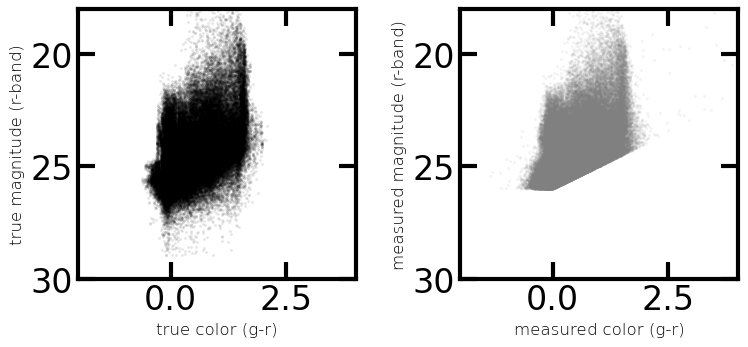

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(-2.5*np.log10(results['ts_flux_g']/results['ts_flux_r']), results['ts_mag_r'], \
           'o', ms=2, alpha=0.1, mew=0, color='black')

ax[1].plot(-2.5*np.log10(results['obj_g_cModelFlux']/results['obj_r_cModelFlux']), results['obj_r_cModelMag'], \
           'o', ms=2, alpha=0.1, mew=0, color='grey')
ax[0].set_xlabel('true color (g-r)', fontsize=12)
ax[0].set_ylabel('true magnitude (r-band)', fontsize=12)
ax[0].set_xlim([-2, 4])
ax[0].set_ylim([30, 18])
ax[1].set_xlabel('measured color (g-r)', fontsize=12)
ax[1].set_ylabel('measured magnitude (r-band)', fontsize=12)
ax[1].set_xlim([-2, 4])
ax[1].set_ylim([30, 18])
plt.tight_layout()
plt.show()

/tmp/ipykernel_64383/3318533333.py:5: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(-2.5*np.log10(results['obj_i_cModelFlux']/results['obj_z_cModelFlux']), results['obj_r_cModelMag'], \


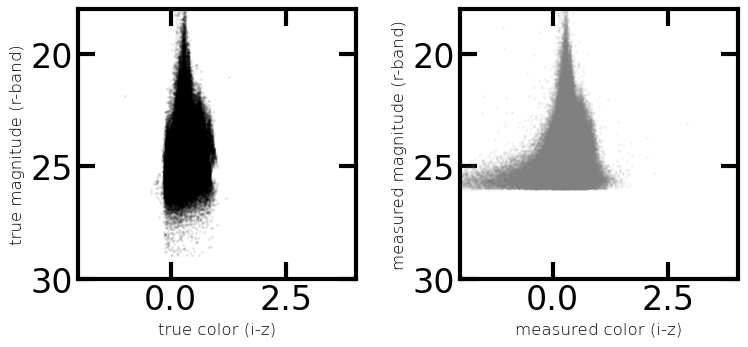

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(-2.5*np.log10(results['ts_flux_i']/results['ts_flux_z']), results['ts_mag_r'], \
           'o', ms=2, alpha=0.1, mew=0, color='black')

ax[1].plot(-2.5*np.log10(results['obj_i_cModelFlux']/results['obj_z_cModelFlux']), results['obj_r_cModelMag'], \
           'o', ms=2, alpha=0.1, mew=0, color='grey')
ax[0].set_xlabel('true color (i-z)', fontsize=12)
ax[0].set_ylabel('true magnitude (r-band)', fontsize=12)
ax[0].set_xlim([-2, 4])
ax[0].set_ylim([30, 18])
ax[1].set_xlabel('measured color (i-z)', fontsize=12)
ax[1].set_ylabel('measured magnitude (r-band)', fontsize=12)
ax[1].set_xlim([-2, 4])
ax[1].set_ylim([30, 18])
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'True reshift distribution')

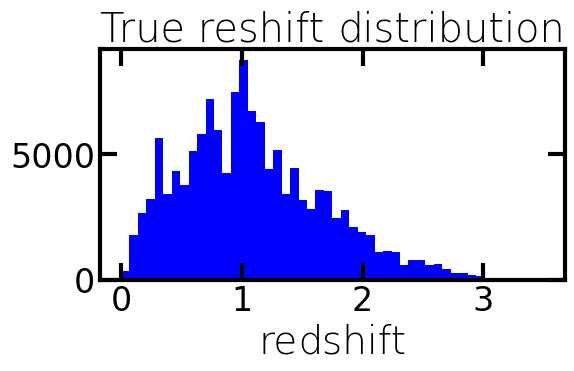

In [63]:
fig = plt.figure(figsize=(6, 3))
ax=fig.add_subplot(1,1,1)
ax.hist(results["ts_redshift"],bins=50,range=(0,3.5),facecolor="b");
ax.set_xlabel("redshift")
ax.set_title("True reshift distribution")